In [1]:
# Import modules and subroutines:
include("../subroutines/Subroutines.jl");

3.10.9


In [2]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

cdata_list = ReadIn("../datasets/pyscf_data/h6_1.25A_sto-3g_052323%1850.hdf5");
chemical_data = cdata_list[1]
PrintChemData(chemical_data)

Molecule name: h6_1.25A
Basis set: sto-3g
Molecular geometry: ../configs/xyz_files/h6_octahedron/1.25.xyz
RHF energy: -2.4237741486662063
FCI energy: -2.7999018858828384


In [3]:
gp = GeomParameters(
    maxiter=100,
)

ord_list, weight_list = GenPermWeights(chemical_data.h2e, 4, gp, verbose=true)

(Any[[2, 5, 1, 4, 3, 6], [4, 6, 5, 2, 1, 3], [4, 6, 3, 2, 5, 1], [5, 4, 3, 6, 1, 2]], Any[22.67333171160694, 6.998999396309952, 1.7493939882897025, 0.08171497307911416])

In [4]:
ord_list = [
    [1,2,3,4,5,6],
    [1,3,5,2,4,6],
    [1,4,2,5,3,6],
    [1,5,2,6,3,4]
]

4-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6]
 [1, 3, 5, 2, 4, 6]
 [1, 4, 2, 5, 3, 6]
 [1, 5, 2, 6, 3, 4]

In [5]:
tnqe0 = GenSubspace(chemical_data, 4, psi_maxdim=4, thresh="projection", eps=1e-12, sweep_num=4, sweep_noise=(1e-2));

"""
opt_ord = InfDistAnnealing(
    Ipq, 
    1, 
    gp,
    verbose=true
)[1]
"""

tnqe0.ord_list = ord_list

GenHams!(tnqe0)
GenStates!(tnqe0, randomize=true)#, ovlp_opt=false, verbose=true)#, ovlp_opt=true, weight=1.0, verbose=true)
#nomps0.psi_list[end] = dmrg(nomps0.ham_list[end], nomps0.psi_list[end], nomps0.dflt_sweeps)[2]
#nomps0.psi_list = reverse(nomps0.psi_list)
GenPermOps!(tnqe0)
GenSubspaceMats!(tnqe0)
SolveGenEig!(tnqe0, verbose=true)

Minimum eigenvalue: -6.642308731301256
Condition number: 2.423057425765438
FCI energy: -2.7999018858828384
Final energy estimate: -2.4151220530044615
Best single ref. estimate: -2.3994386573790045
Error: 0.3847798328783769
BSRfE: 0.40046322850383387
Improvement: 0.015683395625456953
Percentage error reduction: 3.916313536214426
Eigenvalue condition numbers: [0.1094, 0.2531, 0.1582, 0.1674]
Percent correlation energy with single-geometry DMRG: -6.470007095803651
Percent correlation energy with multi-geometry TNQE: -2.300307795902233


In [6]:
M = tnqe0.mparams.M

for i=1:M, j=1:(M-i)
    println(maxlinkdim(tnqe0.perm_ops[i][j]))
end

PrintFSWAPNetworks!(tnqe0)

16
16
256
256
16
59


###### 1-2 ######

1-----1
       
2-x---3
  |    
3-x-x-5
    |  
4-x-x-2
  |    
5-x---4
       
6-----6


###### 1-3 ######

1-----1
       
2---x-4
    |  
3-x-x-2
  |    
4-x-x-5
    |  
5---x-3
       
6-----6


###### 1-4 ######

1-------1
         
2-----x-5
      |  
3---x-x-2
    |    
4-x-x-x-6
  |   |  
5-x-x-x-3
    |    
6---x---4


###### 2-3 ######

1-----------1
             
3-x---x---x-4
  |   |   |  
5-x-x-x-x-x-2
    |   |    
2---x-x-x---5
      |      
4-----x-----3
             
6-----------6


###### 2-4 ######

1-------1
         
3-x-----5
  |      
5-x-x---2
    |    
2---x-x-6
      |  
4-x---x-3
  |      
6-x-----4


###### 3-4 ######

1-----------1
             
4-x---x-----5
  |   |      
2-x-x-x-----2
    |        
5---x-x---x-6
      |   |  
3-----x-x-x-3
        |    
6-------x---4


In [130]:
fci_array = FCIArray(chemical_data)
fci_mps = MPS(fci_array, siteinds("Electron", 6), cutoff=1e-16, maxdim=2^16);

6×6 Matrix{Float64}:
 0.0        0.238507  0.0601123  0.100417   0.0590979  0.457493
 0.238507   0.0       0.478757   0.235363   0.600075   0.449547
 0.0601123  0.478757  0.0        0.923836   0.430417   0.0287143
 0.100417   0.235363  0.923836   0.0        0.488014   0.0616452
 0.0590979  0.600075  0.430417   0.488014   0.0        0.280449
 0.457493   0.449547  0.0287143  0.0616452  0.280449   0.0

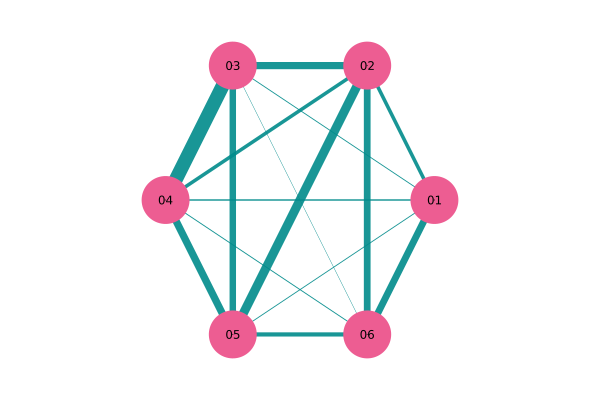

In [131]:
S1, S2, Ipq = MutualInformation(fci_mps, collect(1:chemical_data.N_spt), chemical_data)

display(Ipq)

OrbitalGraphPlot(Ipq, multiplier=1.5e1)

In [7]:
gp1 = GeomParameters(
    maxiter=300000,
    eta=-2,
    shrp=2.0,
    a_alpha=1e0
)

op1 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-8,
    delta=[0.0],
    ttol=10.0,
    theta=0.0,
    sd_method="triple_geneig",
    sd_penalty=0.99999,
    sd_swap_penalty=0.99999
)

op2 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-8,
    delta=[0.0],
    ttol=10.0,
    theta=0.0,
    sd_method="triple_geneig",
    sd_penalty=0.99999,
    sd_swap_penalty=0.9999,
    swap_mult=2.0
)

op3 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-8,
    delta=[0.0],
    ttol=10.0,
    theta=0.0,
    sd_method="triple_geneig",
    sd_penalty=0.99999,
    sd_swap_penalty=0.9999,
    swap_mult=1.0
)

op4 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-8,
    delta=[0.0],
    ttol=10.0,
    theta=0.0,
    sd_method="triple_geneig",
    sd_penalty=0.99999,
    sd_swap_penalty=0.9999,
    swap_mult=0.0
)

op_list = [op1, op2, op3, op4]

4-element Vector{OptimParameters}:
 OptimParameters(1, 1, -1, [0.0], [0.0], 0.0, 10.0, 1.0, "inversion", 1.0e-8, "triple_geneig", "inversion", 1.0e-8, 0.99999, 0.99999, 0.0001)
 OptimParameters(1, 1, -1, [0.0], [0.0], 0.0, 10.0, 2.0, "inversion", 1.0e-8, "triple_geneig", "inversion", 1.0e-8, 0.99999, 0.9999, 0.0001)
 OptimParameters(1, 1, -1, [0.0], [0.0], 0.0, 10.0, 1.0, "inversion", 1.0e-8, "triple_geneig", "inversion", 1.0e-8, 0.99999, 0.9999, 0.0001)
 OptimParameters(1, 1, -1, [0.0], [0.0], 0.0, 10.0, 0.0, "inversion", 1.0e-8, "triple_geneig", "inversion", 1.0e-8, 0.99999, 0.9999, 0.0001)

In [8]:
TwoSitePairSweep!(
    tnqe0,
    op_list[2],
    verbose=true
)

TwoSitePairSweep!(
    tnqe0,
    op_list[2],
    verbose=true
)

OneSitePairSweep!(
    tnqe0,
    op_list[1],
    verbose=true
)


TWO-STATE, TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 8/8; sweep: 1/1; bond: 5/5; E_min = -6.91087; Delta = 0.11621; kappa = 2.32     
Done!


TWO-STATE, TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 8/8; sweep: 1/1; bond: 5/5; E_min = -6.91636; Delta = 0.11072; kappa = 2.3      
Done!


TWO-STATE, ONE-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 8/8; sweep: 1/1; bond: 6/6; E_min = -6.91775; Delta = 0.10934; kappa = 2.71     
Done!



In [187]:
nomps0 = GenSubspace(chemical_data, 4, psi_maxdim=4, thresh="projection", eps=1e-12, sweep_num=4, sweep_noise=(1e-2));

"""
opt_ord = InfDistAnnealing(
    Ipq, 
    1, 
    gp,
    verbose=true
)[1]
"""

opt_ord = [1,6,2,5,4,3]

nomps0.ord_list = [deepcopy(opt_ord) for i=1:nomps0.mparams.M]

GenHams!(nomps0)
GenStates!(nomps0, randomize=true)#, ovlp_opt=false, verbose=true)#, ovlp_opt=true, weight=1.0, verbose=true)
nomps0.psi_list[end] = dmrg(nomps0.ham_list[end], nomps0.psi_list[end], nomps0.dflt_sweeps)[2]
#nomps0.psi_list = reverse(nomps0.psi_list)
GenPermOps!(nomps0)
GenSubspaceMats!(nomps0)
SolveGenEig!(nomps0)

After sweep 1 energy=-7.003432130122845  maxlinkdim=4 maxerr=6.41E-02 time=0.084
After sweep 2 energy=-7.004584352386197  maxlinkdim=4 maxerr=6.28E-02 time=0.085
After sweep 3 energy=-7.005717611939742  maxlinkdim=4 maxerr=6.16E-02 time=0.123
After sweep 4 energy=-7.007019923191753  maxlinkdim=4 maxerr=6.16E-02 time=0.091


In [188]:
CountNonZeros(nomps0.psi_list)

194

In [189]:
CountNonZeros(dmrg10.psi_list)

196

In [190]:
SolveGenEig!(nomps0, thresh="none")
display(nomps0.C)
display(transpose(nomps0.C)*nomps0.S_mat*nomps0.C)

4×4 Matrix{Float64}:
 -0.000972338   0.338678    0.174392   0.925195
  0.00163447   -0.952975    0.0309021  0.307085
 -0.0033591     0.0653303  -0.987261   0.163712
  0.999744      0.0278754  -0.0658441  0.0043329

4×4 Matrix{Float64}:
  1.0           0.0          -6.93889e-17   6.07153e-18
 -1.73472e-18   1.0           4.23571e-16  -9.14423e-17
 -5.55112e-17   4.1445e-16    1.0           1.66577e-17
  4.44523e-18  -1.71592e-16   1.00966e-17   1.0

In [191]:
SolveGenEig!(nomps0, thresh="inversion")
display(nomps0.C)
display(transpose(nomps0.C)*nomps0.S_mat*nomps0.C)

4×4 Matrix{Float64}:
  0.000972338  -0.338678   -0.174392   -0.925195
 -0.00163447    0.952975   -0.0309021  -0.307085
  0.0033591    -0.0653303   0.987261   -0.163712
 -0.999744     -0.0278754   0.0658441  -0.0043329

4×4 Matrix{Float64}:
  1.0          -2.42861e-17  1.92901e-15  4.54498e-16
 -2.42861e-17   1.0          6.93781e-16  5.50967e-15
  1.91123e-15   6.79686e-16  1.0          2.24795e-15
  4.56449e-16   5.52487e-15  2.23605e-15  1.0

In [192]:
SolveGenEig!(nomps0, thresh="projection")
display(nomps0.C)
display(transpose(nomps0.C)*nomps0.S_mat*nomps0.C)

4×4 Matrix{Float64}:
  0.000972338  -0.338678   -0.174392   -0.925195
 -0.00163447    0.952975   -0.0309021  -0.307085
  0.0033591    -0.0653303   0.987261   -0.163712
 -0.999744     -0.0278754   0.0658441  -0.0043329

4×4 Matrix{Float64}:
  1.0          -1.079e-15     1.05471e-15   1.09288e-15
 -1.07856e-15   1.0          -4.75046e-15   1.03389e-14
  1.04734e-15  -4.76992e-15   1.0          -6.22348e-15
  1.09504e-15   1.0295e-14   -6.21692e-15   1.0

In [193]:
println(chemical_data.e_fci - chemical_data.e_nuc)

-7.027088564179633


In [20]:
TwoSitePairSweep!(
    tnqe0,
    op_list[2],
    verbose=true
)

TwoSitePairSweep!(
    tnqe0,
    op_list[2],
    verbose=true
)

OneSitePairSweep!(
    tnqe0,
    op_list[1],
    verbose=true
)

LoadError: UndefVarError: op_list not defined

In [194]:
nomps1 = copy(nomps0)

"""
for k=1:4

    SeedNoise!(
        nomps1,
        0.1,
        0.1,
        penalty=0.0
    )
    
    TwoSitePairSweep!(
        nomps1,
        op_list[2],
        verbose=true
    )
    
end
"""

TwoSitePairSweep!(
    nomps1,
    op_list[2],
    verbose=true
)

TwoSitePairSweep!(
    nomps1,
    op_list[2],
    verbose=true
)

OneSitePairSweep!(
    nomps1,
    op_list[1],
    verbose=true
)


TWO-STATE, TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 8/8; sweep: 1/1; bond: 5/5; E_min = -7.01088; Delta = 0.01621; kappa = 5.75       
Done!


TWO-STATE, TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 8/8; sweep: 1/1; bond: 5/5; E_min = -7.01115; Delta = 0.01594; kappa = 52.5     
Done!


TWO-STATE, ONE-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 8/8; sweep: 1/1; bond: 6/6; E_min = -7.01116; Delta = 0.01592; kappa = 49.5     
Done!



In [ ]:
tnqe1 = copy(tnqe0)

noise_list = [0.02 for s=1:4]
penalty_list = [0.999, 0.9999, 0.9999, 0.9999]

for s=2:4

    for k=1:8
        
        for j_idx=1:tnqe1.mparams.M

            """
            SeedSwaps!(
                tnqe1,
                op_list[s],
                plimit=true,
                penalty=0.999,
                jset = [j_idx]
            )
            """
            
            SeedNoise!(
                tnqe1,
                0.005,
                0.0,
                #jset=[j_idx],
                penalty=0.999
            )
            
            FSwapDisentangle!(
                tnqe1,
                op_list[s],
                jset = [j_idx],
                no_swap=false,
                verbose=true
            )
            
        end
        
        """
        OneSitePairSweep!(
            tnqe1,
            op_list[1],
            verbose=true
        )
        """
        
    end
    
end


FSWAP DISENTANGLER:
State: 1/1; bond: 5/5; #swaps: 0; E_min = -6.93065; Delta = 0.09644; kappa = 3.47     
Done!


FSWAP DISENTANGLER:


In [196]:

TwoSitePairSweep!(
    tnqe1,
    op_list[2],
    verbose=true
)

OneSitePairSweep!(
    tnqe1,
    op_list[1],
    verbose=true
)


TWO-STATE, TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 8/8; sweep: 1/1; bond: 5/5; E_min = -7.02503; Delta = 0.00206; kappa = 19.5     
Done!


TWO-STATE, ONE-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 8/8; sweep: 1/1; bond: 6/6; E_min = -7.02503; Delta = 0.00206; kappa = 19.5     
Done!



In [197]:
display(tnqe1.C)

4×4 Matrix{Float64}:
 -0.508882   0.606373  -0.120105    0.600692
  0.719931   0.69514   -0.0224895  -0.0592577
 -1.13631    0.906815  -0.259341   -1.78773
  0.883253  -0.730528   1.22188     1.60084

In [198]:
op_list[2]

OptimParameters
  maxiter: Int64 1
  numloop: Int64 1
  numopt: Int64 -1
  noise: Array{Float64}((1,)) [0.0]
  delta: Array{Float64}((1,)) [0.0]
  theta: Float64 0.0
  ttol: Float64 10.0
  swap_mult: Float64 2.0
  thresh: String "inversion"
  eps: Float64 1.0e-8
  sd_method: String "triple_geneig"
  sd_thresh: String "inversion"
  sd_eps: Float64 1.0e-8
  sd_penalty: Float64 0.99999
  sd_swap_penalty: Float64 0.9999
  sd_dtol: Float64 0.0001


In [199]:
-7.77346*0.99

-7.6957254

In [200]:
tnqe1.E[1]+chemical_data.e_nuc

-2.797839852400359

EXCITATION LEVEL: 0


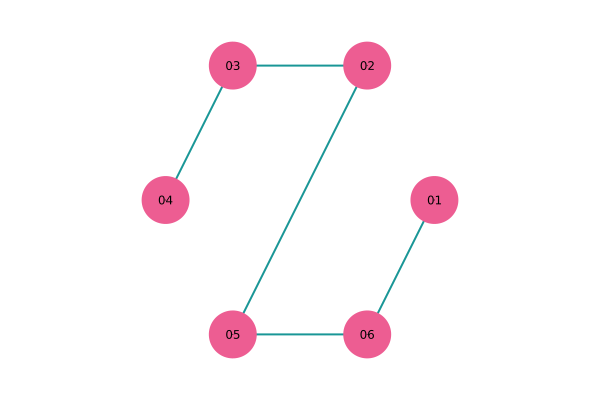

EXCITATION LEVEL: 1


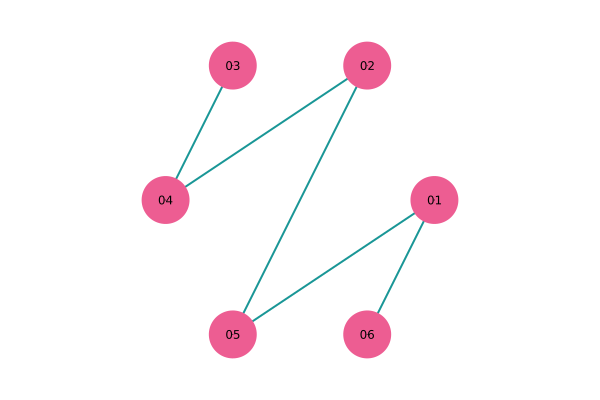

EXCITATION LEVEL: 2


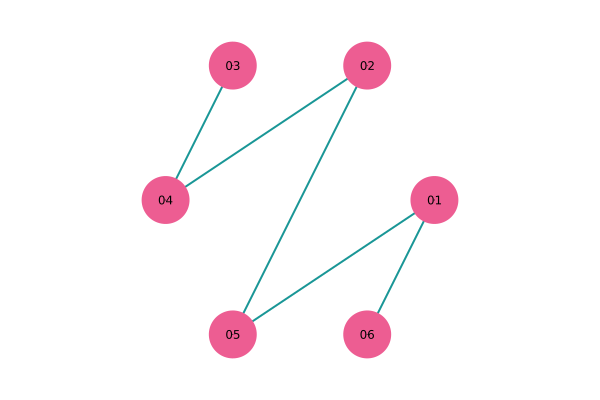

EXCITATION LEVEL: 3


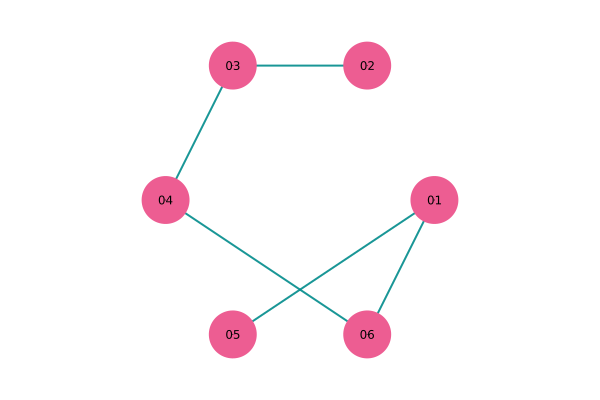

In [201]:
graph_mat_list = []

for (j,ord) in enumerate(tnqe1.ord_list)
    push!(graph_mat_list, GraphMat(ord, directed=false) )
end

for j=1:length(graph_mat_list)
    println("EXCITATION LEVEL: $(j-1)")
    OrbitalGraphPlot(graph_mat_list[j], multiplier=2.0)
end

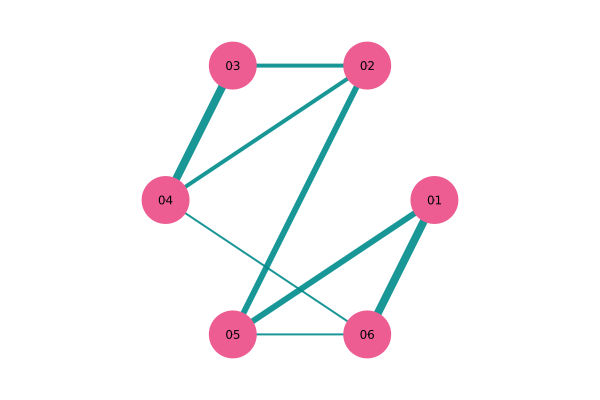

In [202]:
full_graph_mat = sum(graph_mat_list)

OrbitalGraphPlot(full_graph_mat, multiplier=2.0)

In [203]:
display(tnqe1.ord_list)

4-element Vector{Vector{Int64}}:
 [1, 6, 5, 2, 3, 4]
 [6, 1, 5, 2, 4, 3]
 [6, 1, 5, 2, 4, 3]
 [5, 1, 6, 4, 3, 2]

In [204]:
M = tnqe1.mparams.M

for i=1:M, j=1:(M-i)
    println(maxlinkdim(tnqe1.perm_ops[i][j]))
end

16
16
16
1
16
16


In [205]:
PrintFSWAPNetworks!(tnqe1)



###### 1-2 ######

1-x-6
  |  
6-x-1
     
5---5
     
2---2
     
3-x-4
  |  
4-x-3


###### 1-3 ######

1-x-6
  |  
6-x-1
     
5---5
     
2---2
     
3-x-4
  |  
4-x-3


###### 1-4 ######

1---x---5
    |    
6-x-x---1
  |      
5-x-----6
         
2-x---x-4
  |   |  
3-x-x-x-3
    |    
4---x---2


###### 2-3 ######

6-6
   
1-1
   
5-5
   
2-2
   
4-4
   
3-3


###### 2-4 ######

6-x---x-5
  |   |  
1-x-x-x-1
    |    
5---x---6
         
2-x-----4
  |      
4-x-x---3
    |    
3---x---2


###### 3-4 ######

6-x---x-5
  |   |  
1-x-x-x-1
    |    
5---x---6
         
2-x-----4
  |      
4-x-x---3
    |    
3---x---2


In [206]:
CountNonZeros(tnqe1.psi_list)

196

In [224]:
sum_mps = SumMPS(tnqe1, final_ord=opt_ord)

orthogonalize!(sum_mps, 1)
truncate!(sum_mps, maxdim=15)

println(linkdims(sum_mps))

println(inner(sum_mps', nomps0.ham_list[1], sum_mps) + tnqe1.chem_data.e_nuc)

CountNonZeros([sum_mps])

[4, 14, 14, 14, 4]
-2.7043115923060395


166

In [225]:
re_dmrg = dmrg(nomps0.ham_list[1], sum_mps, nsweeps=10, noise=(1e-2,1e-2,1e-3,1e-4,1e-5,1e-6), maxdim=15)[2]

println(inner(re_dmrg', nomps0.ham_list[1], re_dmrg) + tnqe1.chem_data.e_nuc)

After sweep 1 energy=-7.017234700322477  maxlinkdim=15 maxerr=1.11E-01 time=0.284
After sweep 2 energy=-7.01729597484776  maxlinkdim=15 maxerr=1.10E-01 time=0.314
After sweep 3 energy=-7.020218852199875  maxlinkdim=15 maxerr=1.80E-02 time=0.343
After sweep 4 energy=-7.020230929681782  maxlinkdim=15 maxerr=5.07E-03 time=0.303
After sweep 5 energy=-7.020235560793965  maxlinkdim=15 maxerr=3.73E-03 time=0.301
After sweep 6 energy=-7.020238937688055  maxlinkdim=15 maxerr=3.64E-03 time=0.304
After sweep 7 energy=-7.02024063734663  maxlinkdim=15 maxerr=3.64E-03 time=0.298
After sweep 8 energy=-7.020241684915316  maxlinkdim=15 maxerr=3.64E-03 time=0.328
After sweep 9 energy=-7.020242368307958  maxlinkdim=15 maxerr=3.64E-03 time=0.288
After sweep 10 energy=-7.020242751661217  maxlinkdim=15 maxerr=3.64E-03 time=0.290
-2.7930560733661682


In [209]:
swap_prob = 0.5

[Int(floor(swap_prob*randexp()[1])) for k=1:5]

5-element Vector{Int64}:
 0
 1
 1
 1
 2

In [210]:
normalize

normalize (generic function with 7 methods)

In [211]:
using Random

In [212]:
maximum.(randn(10))

10-element Vector{Float64}:
  0.948568937849669
  0.49106634710832087
 -1.1301115351848927
 -1.1636213071172197
  0.6619359391392439
 -0.8842991230879867
 -0.15246032083680947
 -0.46229273278046285
 -2.26882086790979
  0.9847421826911956

In [213]:
collect(6:(-1):7)

Int64[]

In [214]:
rand((1,2))

1